# **<font color=blue>TWITTER SENTIMENT ANALYSIS PROJECT<font>**

#### Group Standard Deviated (Barbieri, Romanelli, Scarpato, Spaziani)

This project aims to achieve a comprehensive understanding of sentiment patterns within the sentiment140 dataset, a collection of 1,600,000 tweets acquired through the Twitter API. The primary goal is twofold: firstly, to  analyze the sentiments expressed in these tweets, and secondly, to construct a robust sentiment analysis model utilizing advanced natural language processing, machine learning and neural network techniques.

The sentiment140 dataset is comprised of tweets that have been annotated with sentiment polarity, with values ranging from 0 for negative, 2 for neutral, to 4 for positive. Each tweet is characterized by essential fields, including sentiment polarity, tweet ID, tweet date, query flag, user details, and the text of the tweet.

## <font color=green> Loading the data <font>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
file_path = '/content/drive/My Drive/training_set.csv'

In [3]:
%%capture
import re
import spacy

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import ToktokTokenizer
from nltk.corpus import stopwords

from wordcloud import WordCloud

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,LSTM,Embedding
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
import nltk

from nltk.stem.porter import *
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
!pip install torch
import random
!pip install datasets
!pip install umap-learn
!pip install transformers[torch] -U



## <font color=green>Data exploration and representation<font>

In [6]:
df_columns=['target','id','date','flag','user','text']
dataset = pd.read_csv(file_path,
                 encoding='ISO-8859-1',
                 names=df_columns)
dataset.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


For the type of analysis we will be conducting, we have decided to drop the `id`,`flag`, and `user` columns, as they are variables that will not influence our analysis.

In [7]:
dataset.drop(['id','flag', 'user'], axis=1, inplace=True)

In [8]:
dataset.head()

,target,date,text
0,0,Mon Apr 06 22:19:45 PDT 2009,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,Mon Apr 06 22:19:49 PDT 2009,is upset that he can't update his Facebook by ...
2,0,Mon Apr 06 22:19:53 PDT 2009,@Kenichan I dived many times for the ball. Man...
3,0,Mon Apr 06 22:19:57 PDT 2009,my whole body feels itchy and like its on fire
4,0,Mon Apr 06 22:19:57 PDT 2009,"@nationwideclass no, it's not behaving at all...."


Next, we substitute the value *4*, denoting positive sentiments, within the `target` column with the value *1*. This transformation establishes a binary variable, where *0* signifies negative sentiments and *1* indicates positive sentiments.

In [9]:
dataset['target'] = dataset['target'].replace(4,1)

We then checked for missing values, but none were found.

In [10]:
dataset.isnull().sum()

target    0
date      0
text      0
dtype: int64

## <font color=green>Data Visualization

### <font color=green>Bar chart

#### <font color=green>Positive and Negative sentiments

We decided to visualize the frequency of positive and negative sentiments through a bar chart.

<ipython-input-11-8e497fbd6242>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=dataset, x='target', palette="bright")
<ipython-input-11-8e497fbd6242>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Negative', 'Positive'])


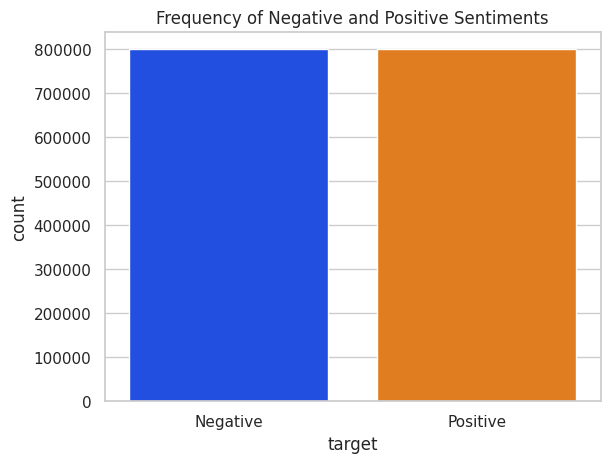

In [11]:
sns.set(style="whitegrid")
ax = sns.countplot(data=dataset, x='target', palette="bright")

ax.set_xticklabels(['Negative', 'Positive'])
plt.title('Frequency of Negative and Positive Sentiments')

plt.show()

In [12]:
dataset['target'].value_counts()

target
0    800000
1    800000
Name: count, dtype: int64

We can observe that our dataset is perfectly balanced, with exactly half of the data having a negative sentiment and the other half having a positive sentiment.

#### <font color=green>Date Vs Sentiment

We are interested in examining how tweets with positive and negative sentiments are distributed over time, utilizing a vertical bar chart.

We are converting the date column into datetime format to facilitate temporal analysis.

In [13]:
dataset['date'] = pd.to_datetime(dataset['date'])

/usr/local/lib/python3.10/dist-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


In [14]:
dataset['date'] = dataset['date'].dt.date

In [15]:
dataset['date'].head()

0    2009-04-06
1    2009-04-06
2    2009-04-06
3    2009-04-06
4    2009-04-06
Name: date, dtype: object

In [16]:
import plotly.express as px

data_sentiment_counts = dataset.groupby(['date', 'target']).size().unstack(fill_value=0)

data_sentiment_counts.rename(columns={0: 'Negative Tweets', 1: 'Positive Tweets'}, inplace=True)

fig = px.bar(data_sentiment_counts, x=data_sentiment_counts.index, y=['Negative Tweets', 'Positive Tweets'],
             title='Counting tweets over the time')

fig.update_layout(yaxis_title='Counting Tweets',xaxis_title='Date')

# removing the counts above the bars
fig.update_traces(text=None)

fig.update_xaxes(tickvals=['2009-04-06', '2009-05-01', '2009-06-01'], title_text="")

fig.show()

### <font color=green>Boxplot

#### <font color=green>Lenght Vs Sentiment

We want to visualize the tweet length based on sentiment using a boxplot.

In [17]:
%%capture
!pip install dash

In the boxplot below, there are some extreme values, especially in the distribution of tweet lengths of the positive sentiment. However, the boxplots show a similar pattern.

In [18]:
from dash import Dash, dcc, html, Input, Output
import plotly.express as px

dataset['Tweet_Length'] = dataset['text'].apply(len)

app = Dash(__name__) #initialize the Dash

# here we define our layout code
app.layout = html.Div([
    html.H4("Boxplot sentiment VS. tweet length"),
    html.P(""),
    dcc.Checklist(
        id='box-plots-x-x-axis',
        value=['target'],

        inline=True
    ),
    html.P(""),
    dcc.RadioItems(
        id='box-plots-x-y-axis',
        value='Tweet_Length',
        inline=True
    ),
    dcc.Graph(id="box-plots-x-graph"),
])


@app.callback(
    Output("box-plots-x-graph", "figure"),
    Input("box-plots-x-x-axis", "value"),
    Input("box-plots-x-y-axis", "value"))
def generate_chart(x, y):
    df = px.data.tips() # replace with our data source
    fig = px.box(dataset, x=x, y=y)
    return fig


if __name__ == "__main__":   #run the web server
    app.run_server(debug=True)

<IPython.core.display.Javascript object>

## <font color=green>Dataset reduction

Due to the large size of our dataset and for more efficient processing, we have decided to reduce its size. Maintaining the originial equilibrium between negative and positive tweets, we performed a random sample selection of 150,000 values from each subgroup. This strategic reduction has resulted in a more manageable dataset, that we named `new_dataset`, decreasing from 1,600,000 to 300,000 values.

In [19]:
neg_tweets = dataset[dataset['target'] == 0]
pos_tweets = dataset[dataset['target'] == 1]

neg_tweets_sub = neg_tweets.sample(150000,random_state = 20128)
pos_tweets_sub = pos_tweets.sample(150000,random_state = 20128)

new_dataset = pd.concat([neg_tweets_sub, pos_tweets_sub])

In [20]:
new_dataset.head()

,target,date,text,Tweet_Length
148479,0,2009-05-22,@accesshollywood this link doesnt work!!,41
741760,0,2009-06-21,"Mmmm, fruit salad. I don't like watermelon muc...",65
739380,0,2009-06-21,my frnds arent letting me watch d match n som...,109
612811,0,2009-06-18,@Xx_JessicaB_xX kind of now yeah :-/ i had som...,95
338052,0,2009-06-03,Should have stated TUES 26 MAY 22.35 - check-...,136


In [21]:
new_dataset.tail()

,target,date,text,Tweet_Length
1177653,1,2009-05-31,"@andreaway Ah, lucky byotch. I'm so jealous ...",138
1430131,1,2009-06-06,@Bkniceguy ~ We need to rap....,32
984766,1,2009-05-18,@astridangeline @muntedhead HAHA love the nick...,89
1342350,1,2009-06-04,Glad I have Abs.Got bit in the tummy by a Hors...,136
1166410,1,2009-05-31,just finished moving back to florida,38


In [22]:
new_dataset.shape

(300000, 4)

## <font color=green>Cleaning of the dataset

To perform effective sentiment analysis, it is crucial to ensure that the data, particularly the text associated with our tweets, are clean. This involves removing elements that could interfere with the accurate interpretation of the text, such as:


1.   URLs
2.   Usernames
3.   Lowercasing
4.   Numbers
5.   Special characters
6.   Removing words with a length less than 3 characters

In [23]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
new_dataset['text'] = new_dataset['text'].apply(lambda x: cleaning_URLs(x))

new_dataset['text'] = new_dataset['text'].apply(lambda x: re.sub(r"@[\w]*", "", x))


df_dirty = new_dataset.copy()


new_dataset['text']=new_dataset['text'].str.lower()

new_dataset['text'] = new_dataset['text'].apply(lambda x: re.sub(r'[0-9]+', '', x))

new_dataset['text'] = new_dataset['text'].str.replace("[^a-zA-Z#]", " ", regex=True)

new_dataset['text'] = new_dataset['text'].apply(lambda x: " ".join([w for w in x.split() if len(w)>=3]))


df_lstm = new_dataset.copy()


new_dataset.head()

,target,date,text,Tweet_Length
148479,0,2009-05-22,this link doesnt work,41
741760,0,2009-06-21,mmmm fruit salad don like watermelon much any ...,65
739380,0,2009-06-21,frnds arent letting watch match some fucking p...,109
612811,0,2009-06-18,kind now yeah had some more strawberries but t...,95
338052,0,2009-06-03,should have stated tues may check and flight w...,136


From the chunk above, we create a copy of the dataset called `df_dirty`, cleaned of URLs and usernames. This copy will be used later for VADER, since this model leverages on uppercase letters and punctuation, and for the Transformer Based Approach. Meanwhile, a second completely clean dataset named `df_lstm` is created for building the Neural Network model.

### <font color=green>Tokenization with `RegexpTokenizer`




In the field of *Natural Language Processing* (**NLP**), tokenization is a fundamental step involving the decomposition of text into smaller units, commonly words or subwords. Python's `nltk` library offers various tools for tokenization and among those we employed `RegexpTokenizer` for its less generic nature and the need for a more tailored approach.

Specifically, the chosen regular expression `r'\w+'` instructs the tokenizer to identify word boundaries and consider the remaining alphanumeric sequences as individual tokens.


In [24]:
tokenizer = RegexpTokenizer(r'\w+')

new_dataset['text'] = new_dataset['text'].apply(lambda x: tokenizer.tokenize(x))

new_dataset['text'].head()

148479                           [this, link, doesnt, work]
741760    [mmmm, fruit, salad, don, like, watermelon, mu...
739380    [frnds, arent, letting, watch, match, some, fu...
612811    [kind, now, yeah, had, some, more, strawberrie...
338052    [should, have, stated, tues, may, check, and, ...
Name: text, dtype: object

### <font color=green> Wordclouds



In our analysis of sentiments, we use word clouds for visual insights. We generate two separate representations — one highlighting negative expressions and the other depicting positive ones. Each word cloud captures the core of its sentiment, displaying the most frequently used words that convey the emotional tone.

(-0.5, 1599.5, 799.5, -0.5)

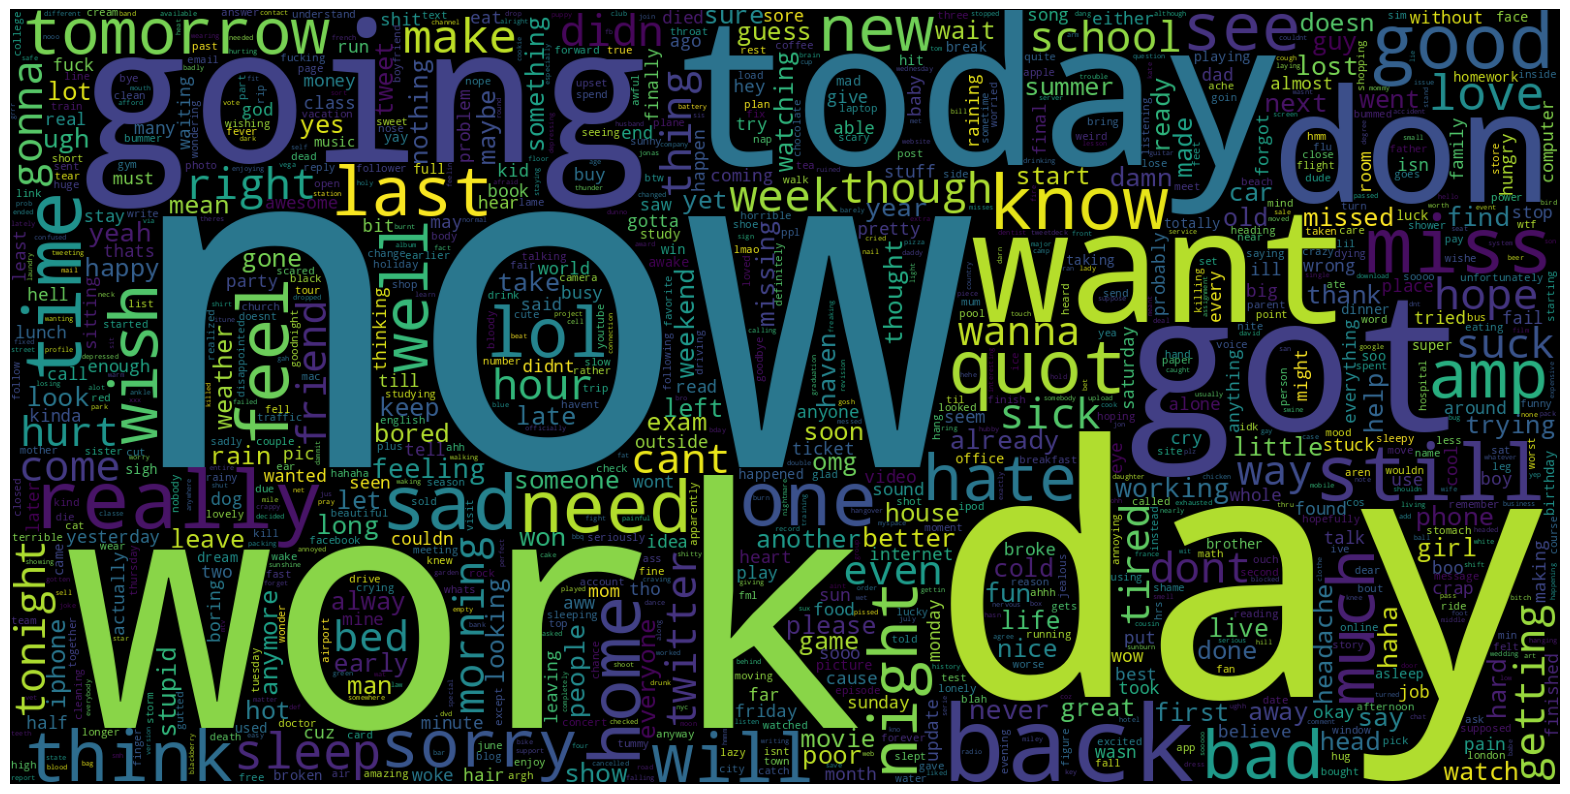

In [25]:
word_neg = new_dataset[new_dataset['target']==0]['text'].apply(lambda x: ' '.join(x) )
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(word_neg))
plt.imshow(wc)
plt.axis('off')

(-0.5, 1599.5, 799.5, -0.5)

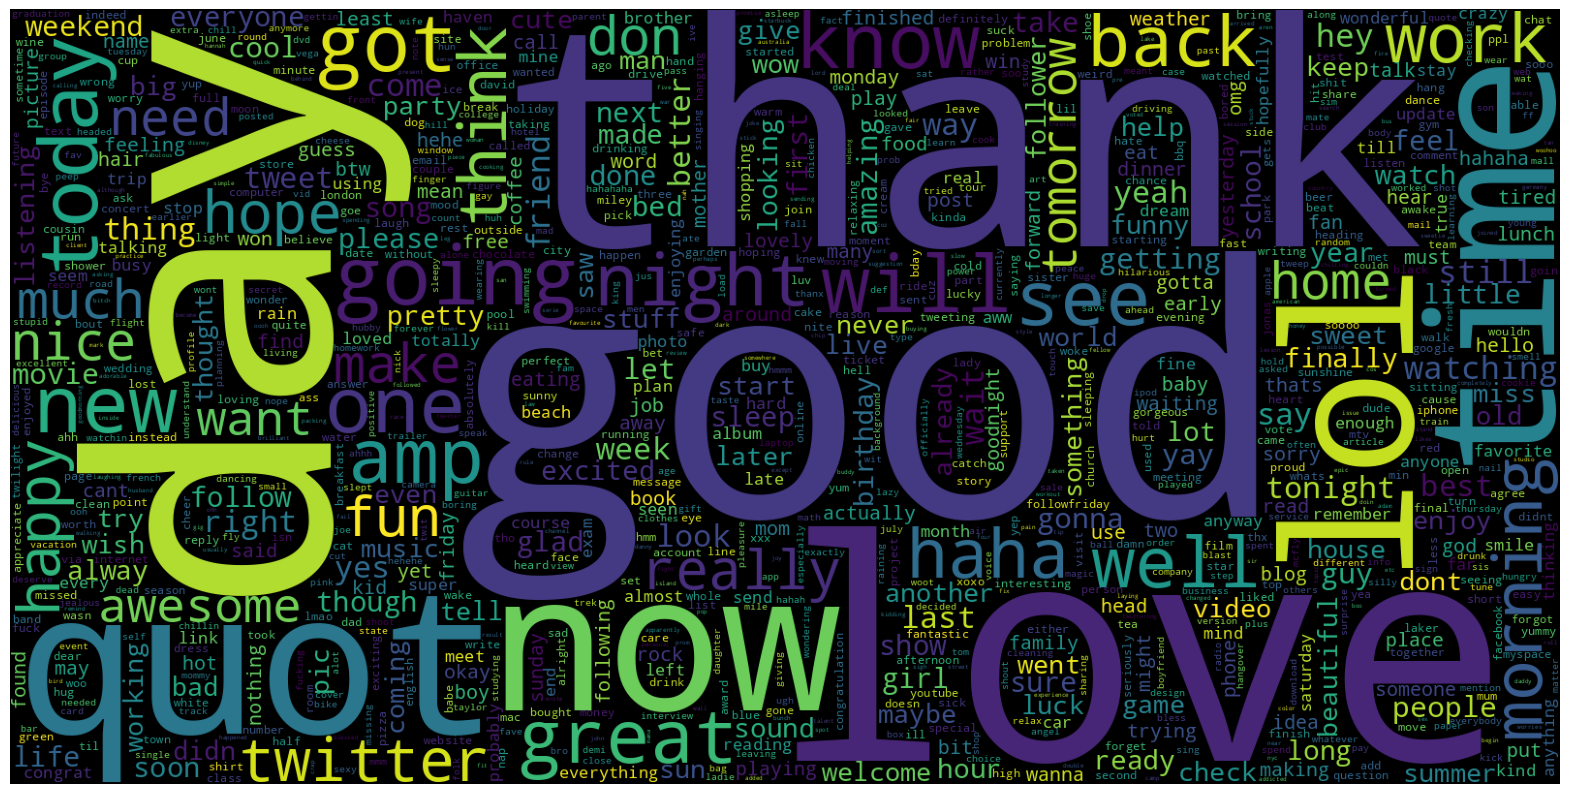

In [26]:
word_pos = new_dataset[new_dataset['target']==1]['text'].apply(lambda x: ' '.join(x) )
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(word_pos))
plt.imshow(wc)
plt.axis('off')

### <font color=green> Stemming

Stemming is a crucial step to enhance the efficiency of our analysis. Leveraging the `NLTK` library and its `Porter Stemmer`, we apply a systematic stemming process to the text data within our dataset. This process helps make words simpler and more consistent, making it easier to analyze text and extract important meaning. Additionally, stemming is employed to reduce the dimensionality of our vectorization matrix, thereby increasing the importance of each stemmed word in the matrix.

In [27]:
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return text
new_dataset['text']= new_dataset['text'].apply(lambda x: stemming_on_text(x))
new_dataset['text'].head()

148479                            [thi, link, doesnt, work]
741760    [mmmm, fruit, salad, don, like, watermelon, mu...
739380    [frnd, arent, let, watch, match, some, fuck, p...
612811    [kind, now, yeah, had, some, more, strawberri,...
338052    [should, have, state, tue, may, check, and, fl...
Name: text, dtype: object

## <font color=green>VADER analysis for sentiment detection

In this analysis phase, we leverage **VADER** (*Valence Aware Dictionary and sEntiment Reasoner*), a pre-trained sentiment analysis tool from the `NLTK` library.

The process involves calculating sentiment scores for each tweet, covering positive, neutral, and negative sentiments. The compound score is then derived, reflecting the overall sentiment of the text.
To facilitate a binary classification, we introduced a new column `compound_score` derived from applying a compound score threshold. Texts with a compound score equal to or above zero are categorized as positive (1), while those below zero are labeled as negative (0).

In [28]:
sid = SentimentIntensityAnalyzer()
df_dirty['scores'] = df_dirty['text'].apply(lambda text: sid.polarity_scores(text))
df_dirty['compound']  = df_dirty['scores'].apply(lambda score_dict: score_dict['compound'])
df_dirty['comp_score'] = df_dirty['compound'].apply(lambda c: 1 if c >=0 else 0)

df_dirty.head()

,target,date,text,Tweet_Length,scores,compound,comp_score
148479,0,2009-05-22,this link doesnt work!!,41,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,1
741760,0,2009-06-21,"Mmmm, fruit salad. I don't like watermelon muc...",65,"{'neg': 0.19, 'neu': 0.81, 'pos': 0.0, 'compou...",-0.2755,0
739380,0,2009-06-21,my frnds arent letting me watch d match n som...,109,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,1
612811,0,2009-06-18,kind of now yeah :-/ i had some more strawber...,95,"{'neg': 0.083, 'neu': 0.625, 'pos': 0.292, 'co...",0.6124,1
338052,0,2009-06-03,Should have stated TUES 26 MAY 22.35 - check-...,136,"{'neg': 0.13, 'neu': 0.87, 'pos': 0.0, 'compou...",-0.5106,0


The `accuracy_score()` function calculates the accuracy of the sentiment predictions by comparing how many of them match the true labels.

In [29]:
print(f'The accuracy is: {accuracy_score(df_dirty["target"], df_dirty["comp_score"])}')


The accuracy is: 0.6608333333333334


In [30]:
print(classification_report(df_dirty['target'],df_dirty['comp_score']))

              precision    recall  f1-score   support

           0       0.81      0.42      0.56    150000
           1       0.61      0.90      0.73    150000

    accuracy                           0.66    300000
   macro avg       0.71      0.66      0.64    300000
weighted avg       0.71      0.66      0.64    300000



The 66% accuracy can be explained by the fact that Vader is an approximate model, meaning it is unable to detect sarcasm, irony...

<Axes: >

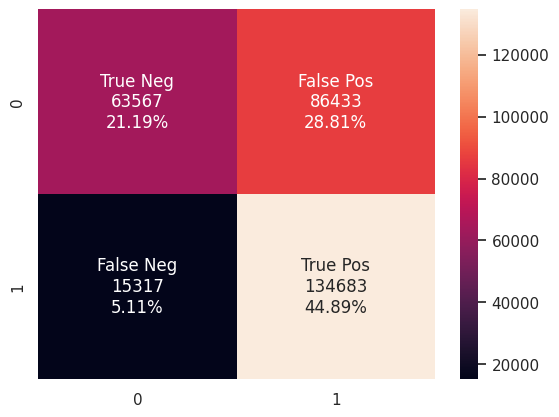

In [31]:
cf_matrix  = confusion_matrix(df_dirty['target'],df_dirty['comp_score'])
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='')

### <font color=green>Introducing the Compound metric column on the cleaned dataset

In [32]:
dataset_compound = pd.concat([new_dataset, df_dirty['compound']], axis=1)
dataset_compound.head()

,target,date,text,Tweet_Length,compound
148479,0,2009-05-22,"[thi, link, doesnt, work]",41,0.0000
741760,0,2009-06-21,"[mmmm, fruit, salad, don, like, watermelon, mu...",65,-0.2755
739380,0,2009-06-21,"[frnd, arent, let, watch, match, some, fuck, p...",109,0.0000
612811,0,2009-06-18,"[kind, now, yeah, had, some, more, strawberri,...",95,0.6124
338052,0,2009-06-03,"[should, have, state, tue, may, check, and, fl...",136,-0.5106


## <font color=green>Vectorization of the tweets

In our journey towards sentiment analysis, the next phase involves `text` vectorization.

To facilitate this, we've transformed the text column in our dataset, converting lists of words into continuous strings. Utilizing the *Term Frequency-Inverse Document Frequency* (**TF-IDF**) vectorization technique with English stop words removed, we convert these textual representations into numerical vectors. The outcome is a dataset enhanced with vectorized features, marking a pivotal step in readying the data for machine learning models.

TF-IDF assigns a lower weight to common but less informative words compared to less common but more significant words for the text's content. This methodology contributes to a more accurate representation of the text, emphasizing words that carry more meaning.

In preparation for the upcoming machine learning tasks, we split the vectorized dataset into training and test sets, allocating 75% of the data for training and reserving 25% for testing.

In [33]:
# convert the 'text' column to strings by joining the lists if they are present
new_dataset['text'] = new_dataset['text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

tfidf = TfidfVectorizer(stop_words='english')

# trains the vectorizer using the data in the 'text' column of new_dataset and transforms this data into a TF-IDF representation.
X_tfdif = tfidf.fit_transform(new_dataset['text'])

y = new_dataset['target']

X_train, X_test, y_train, y_test = train_test_split(X_tfdif, y, test_size=0.25, random_state=24)

## <font color=green>Computing Machine Learning

In [34]:
print('Training Data Shape:', X_train.shape)
print('Testing Data Shape: ', X_test.shape)

Training Data Shape: (225000, 79449)
Testing Data Shape:  (75000, 79449)


### <font color=green>Random Forest

For this analysis, the application of machine learning models plays a pivotal role in classifying sentiments within text data.
One such approach is the utilization of **Random Forest**, a simple model, that we will be using as a baseline benchmark for our binary classification problem.

This model belongs to the family of ensemble learning methods, where it constructs a multitude of decision trees during training. Each tree is trained on a random subset of the data, and randomness is introduced in feature selection for each tree.

Random Forest is often used as a baseline benchmark in machine learning projects due to its simplicity and effectiveness. It serves as a robust starting point, especially for classification problems, and can be a valuable reference for evaluating more complex models.







In [35]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=5)

clf.fit(X_train, y_train)

print("train score:", clf.score(X_train, y_train))
print("test score:", clf.score(X_test,y_test))

train score: 0.9563911111111111
test score: 0.71488


In [36]:
predictions_RF = clf.predict(X_test)

print(metrics.classification_report(y_test, predictions_RF,  digits=5))
RandomForest_metrics= pd.DataFrame(metrics.confusion_matrix(y_test, predictions_RF),index=['0','1'], columns = ['0','1'])

              precision    recall  f1-score   support

           0    0.71609   0.70850   0.71227     37358
           1    0.71371   0.72122   0.71744     37642

    accuracy                        0.71488     75000
   macro avg    0.71490   0.71486   0.71486     75000
weighted avg    0.71489   0.71488   0.71487     75000



### <font color=green>Naive Bayes approach (BernoulliNB)



Next, we introduce **Bernoulli Naive Bayes**, a classification algorithm particularly suitable for binary sentiment tasks. The Bernoulli Naive Bayes model is adept at handling features that are binary in nature, making it a practical choice for scenarios where the presence or absence of specific words or features contributes to sentiment categorization.

Two key aspects characterize the functioning of Naive Bayes:

1. The "naive" assumption assumes that features are *independent* of each other, given the class variable. This simplification, while not always accurate, greatly reduces the computational complexity of the model.

2. For classification purposes, Naive Bayes computes the probability of belonging to each class based on the features of an instance. The class with the highest probability becomes the model's prediction.

In [37]:
from sklearn.naive_bayes import BernoulliNB

bernoulli_model = BernoulliNB()
bernoulli_model.fit(X_train, y_train)


predictions_bernoulli = bernoulli_model.predict(X_test)

bernoulli_metrics= pd.DataFrame(metrics.confusion_matrix(y_test, predictions_bernoulli),index=['0','1'], columns = ['0','1'])
bernoulli_metrics

,0,1
0,27994,9364
1,8952,28690


The confusion matrix provides a snapshot of the model's performance on the test data. Here's a breakdown of the key metrics:

In [38]:
print(metrics.classification_report(y_test, predictions_bernoulli))

              precision    recall  f1-score   support

           0       0.76      0.75      0.75     37358
           1       0.75      0.76      0.76     37642

    accuracy                           0.76     75000
   macro avg       0.76      0.76      0.76     75000
weighted avg       0.76      0.76      0.76     75000



### <font color=green>Logistic approach

The **Logistic Regression** steps into the spotlight as our third machine learning model.

Logistic Regression is a statistical method commonly applied to binary classification problems, aiming to predict the probability of an instance belonging to a specific class.

In [39]:
log_model = LogisticRegression(solver = 'lbfgs', max_iter=500,random_state=50126)
log_model.fit(X_train, y_train)
predictions_log = log_model.predict(X_test)
log_metrics = pd.DataFrame(metrics.confusion_matrix(y_test, predictions_log), index=['0','1'], columns = ['0','1'])
log_metrics

,0,1
0,27629,9729
1,7937,29705


In [40]:
print(metrics.classification_report(y_test, predictions_log))

              precision    recall  f1-score   support

           0       0.78      0.74      0.76     37358
           1       0.75      0.79      0.77     37642

    accuracy                           0.76     75000
   macro avg       0.77      0.76      0.76     75000
weighted avg       0.77      0.76      0.76     75000



The Logistic model achieves an accuracy of 76%, indicating that it correctly predicted the outcomes for approximately 76% of the instances. This is a slight improvement compared to the Random Forest model, which had an accuracy of 71%.

### <font color=green>SVC model

The last fitted ML model is the **Support Vector Classifier** (SVC) model, embodied by the `svc_model`.

SVC is a powerful tool for solving classification problems by finding an optimal hyperplane that separates different classes of data points with maximum margin. By calculating distances from data points to this hyperplane, classification becomes possible based on which side they fall on.



In [41]:
svc_model = LinearSVC(random_state = 70020)
svc_model.fit(X_train, y_train)
predictions_SVC = svc_model.predict(X_test)
SVC_metrics = pd.DataFrame(metrics.confusion_matrix(y_test, predictions_SVC))
SVC_metrics

,0,1
0,27381,9977
1,8420,29222


In [42]:
print(metrics.classification_report(y_test, predictions_SVC ))

              precision    recall  f1-score   support

           0       0.76      0.73      0.75     37358
           1       0.75      0.78      0.76     37642

    accuracy                           0.75     75000
   macro avg       0.76      0.75      0.75     75000
weighted avg       0.76      0.75      0.75     75000



The accuracy of the SVC model is 75%, showing a 1% decrease compared to the other model, except for the Random Forest model, which remains the least accurate.


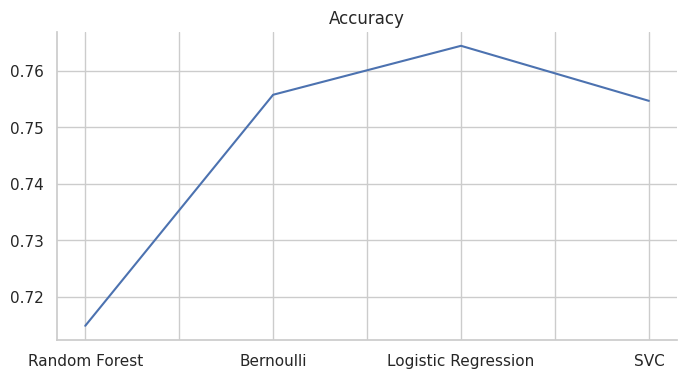

In [43]:
# collect accuracy scores into a list
accuracies = [
    metrics.accuracy_score(y_test, predictions_RF),
    metrics.accuracy_score(y_test, predictions_bernoulli),
    metrics.accuracy_score(y_test, predictions_log),
    metrics.accuracy_score(y_test, predictions_SVC),
]

# create a DataFrame with only the accuracy column
results_df = pd.DataFrame({"Accuracy": accuracies}, index=["Random Forest", "Bernoulli", "Logistic Regression", "SVC"])

from matplotlib import pyplot as plt
results_df['Accuracy'].plot(kind='line', figsize=(8, 4), title='Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

## <font color=green>Vectorization for compound dataset

Now we embark on a crucial step of our analysis by introducing the compound feature into our dataset.
This new feature, derived from sentiment analysis using the VADER tool, encapsulates the overall sentiment polarity of each tweet instance.

In [44]:
dataset_compound['text'] = dataset_compound['text'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)
dataset_compound.tail()

,target,date,text,Tweet_Length,compound
1177653,1,2009-05-31,lucki byotch jealou practic green haven been t...,138,-0.6669
1430131,1,2009-06-06,need rap,32,0.0000
984766,1,2009-05-18,haha love the nicknam kemaren nginep cal but n...,89,0.7043
1342350,1,2009-06-04,glad have ab got bit the tummi hors but didnt ...,136,0.2675
1166410,1,2009-05-31,just finish move back florida,38,0.0000


In [45]:
corpus = new_dataset['text'].tolist()
yc = dataset_compound['target']

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', max_features=200)
Xcp_tfdif = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names_out()
dfXc_tfidf = pd.DataFrame(data=Xcp_tfdif.toarray(), columns=feature_names, index=dataset_compound.index)
dfXc_tfidf.tail()

,actual,alreadi,alway,amaz,amp,ani,anoth,away,awesom,babi,...,won,wonder,work,world,wow,yay,ye,yeah,year,yesterday
1177653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1430131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
984766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1342350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1166410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
dfXc_tfidf.shape

(300000, 200)

In [48]:
result = pd.concat([dfXc_tfidf, dataset_compound['compound']], axis=1)
result.tail()

,actual,alreadi,alway,amaz,amp,ani,anoth,away,awesom,babi,...,wonder,work,world,wow,yay,ye,yeah,year,yesterday,compound
1177653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.6669
1430131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000
984766,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7043
1342350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2675
1166410,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000


In [49]:
result.shape

(300000, 201)

In [50]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(result, yc, test_size=0.25, random_state=40026)

## <font color=green>Logistic approach for compound dataset

Having augmented our dataset, we move forward to train our "best" machine learning model, which happens to be the Logistic Regression model, in order to investigate the influence of the newly added compound sentiment feature on predictive performance. It's worth noting that the Vader model achieves an accuracy of 66% (which is not particularly high), and therefore, we do not anticipate a significant enhancement in the performance of our machine learning model.

In [51]:
log_model_comp = LogisticRegression(max_iter=500,random_state=50126)
log_model_comp.fit(X_train1, y_train1)
predictions_log_comp = log_model_comp.predict(X_test1)

log_metrics_comp = pd.DataFrame(metrics.confusion_matrix(y_test1, predictions_log_comp))

log_metrics_comp

,0,1
0,25793,11800
1,8300,29107


In [52]:
print(metrics.classification_report(y_test1, predictions_log_comp))

              precision    recall  f1-score   support

           0       0.76      0.69      0.72     37593
           1       0.71      0.78      0.74     37407

    accuracy                           0.73     75000
   macro avg       0.73      0.73      0.73     75000
weighted avg       0.73      0.73      0.73     75000



The incorporation of the Vader-derived compound feature was not expected to enhance the logistic model's accuracy, indeed it incurred a 3% decrease.

##  <font color=green>Neural Network - LSTM based

**LSTM** is a type of *Recurrent Neural Network* (**RNN**) architecture designed to overcome the limitations of traditional RNNs in capturing long-term dependencies in sequential data. While RNNs can struggle with vanishing or exploding gradients, LSTMs are specifically crafted to mitigate these issues.

In [53]:
df_lstm.head()

,target,date,text,Tweet_Length
148479,0,2009-05-22,this link doesnt work,41
741760,0,2009-06-21,mmmm fruit salad don like watermelon much any ...,65
739380,0,2009-06-21,frnds arent letting watch match some fucking p...,109
612811,0,2009-06-18,kind now yeah had some more strawberries but t...,95
338052,0,2009-06-03,should have stated tues may check and flight w...,136


We set the maximum number of unique words to consider, so only the most frequent 10000 words will be taken into account.

By using the function `.texts_to_sequences()`, we convert each text to a sequence of integers based on the mapping learned by the `tokenizer`.


The function `pad_sequences()`, pads the sequences with zeros so that they all have the same length.

In [54]:
max_features = 10000

tokenizer = Tokenizer(num_words=max_features, split=' ')

tokenizer.fit_on_texts(df_lstm['text'].values)
word_index = tokenizer.word_index
input_dim = len(word_index) + 1
X = tokenizer.texts_to_sequences(df_lstm['text'].values)
X = pad_sequences(X)

In [55]:
X

array([[   0,    0,    0, ...,  489,  649,   26],
       [   0,    0,    0, ...,  147,   61,   97],
       [   0,    0,    0, ...,  490,    1, 2018],
       ...,
       [   0,    0,    0, ...,    7,   10,  344],
       [   0,    0,    0, ..., 2376, 3068, 2175],
       [   0,    0,    0, ...,  642,   33, 1641]], dtype=int32)

In [56]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense, Dropout
modelQA = Sequential()
modelQA.add(Embedding(5000, 500, input_length=X.shape[1]))
modelQA.add(LSTM(200))
modelQA.add(Dropout(0.5))
modelQA.add(Dense(2, activation='softmax'))

# Compilazione del modello
modelQA.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(modelQA.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 500)           2500000   
                                                                 
 lstm (LSTM)                 (None, 200)               560800    
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 2)                 402       
                                                                 
Total params: 3061202 (11.68 MB)
Trainable params: 3061202 (11.68 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


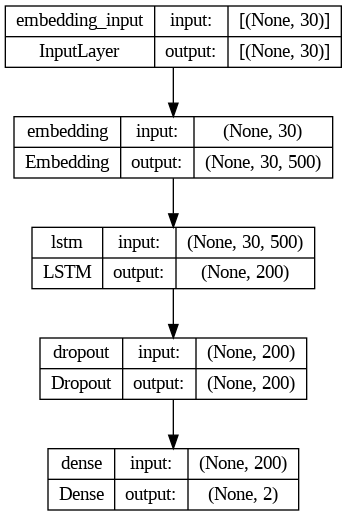

In [57]:
plot_model(modelQA, show_shapes=True, show_layer_names=True)

*Embedding Layer*:
*   Input: Vocabulary size of 5000 words.
*   Output: Embedding vectors of size 500 for each word.
*   Input Length: Determined by the shape of your input data X.

*LSTM Layer*: Long Short-Term Memory (LSTM) layer with 200 units.
This layer captures long-term dependencies in the input sequences.

*Dropout Layer*: Dropout of 0.5 is applied to prevent overfitting by randomly setting a fraction of input units to zero during training.


*Dense Layer* with Softmax Activation: Output layer with 2 units (binary classification for QA).
Softmax activation function is used to obtain probabilities for each class.


In [58]:
Y = pd.get_dummies(df_lstm['target']).values # defining the variable Y as a dummie variable
Y

array([[ True, False],
       [ True, False],
       [ True, False],
       ...,
       [False,  True],
       [False,  True],
       [False,  True]])

In [59]:
Xnn_train, Xnn_test, Ynn_train, Ynn_test = train_test_split(X,Y, test_size = 0.25, random_state = 40026)
print(Xnn_train.shape,Ynn_train.shape)
print(Xnn_test.shape,Ynn_test.shape)

(225000, 30) (225000, 2)
(75000, 30) (75000, 2)


The parameter `batch_size` is set to 32. It specifies the number of samples processed in each iteration during training, setting it to 32 means that the neural network updates its weights after processing 32 data samples in each training iteration.




In [60]:
batch_size = 32
fittingQA = modelQA.fit(Xnn_train, Ynn_train, epochs=10,  batch_size=batch_size,verbose=2)
fittingQA

Epoch 1/10
7032/7032 - 65s - loss: 0.4715 - accuracy: 0.7749 - 65s/epoch - 9ms/step
Epoch 2/10
7032/7032 - 38s - loss: 0.4266 - accuracy: 0.8014 - 38s/epoch - 5ms/step
Epoch 3/10
7032/7032 - 38s - loss: 0.4011 - accuracy: 0.8151 - 38s/epoch - 5ms/step
Epoch 4/10
7032/7032 - 38s - loss: 0.3769 - accuracy: 0.8271 - 38s/epoch - 5ms/step
Epoch 5/10
7032/7032 - 38s - loss: 0.3518 - accuracy: 0.8399 - 38s/epoch - 5ms/step
Epoch 6/10
7032/7032 - 38s - loss: 0.3258 - accuracy: 0.8525 - 38s/epoch - 5ms/step
Epoch 7/10
7032/7032 - 38s - loss: 0.2986 - accuracy: 0.8657 - 38s/epoch - 5ms/step
Epoch 8/10
7032/7032 - 38s - loss: 0.2736 - accuracy: 0.8771 - 38s/epoch - 5ms/step
Epoch 9/10
7032/7032 - 37s - loss: 0.2517 - accuracy: 0.8880 - 37s/epoch - 5ms/step
Epoch 10/10
7032/7032 - 38s - loss: 0.2327 - accuracy: 0.8970 - 38s/epoch - 5ms/step


In [61]:
predictions = modelQA.predict(Xnn_test)
predictions

2344/2344 [==============================] - 6s 3ms/step


array([[9.8870474e-01, 1.1295271e-02],
       [9.6282834e-01, 3.7171721e-02],
       [9.9091184e-01, 9.0881754e-03],
       ...,
       [4.7685285e-03, 9.9523145e-01],
       [1.0000000e+00, 2.3524763e-08],
       [3.0968308e-06, 9.9999690e-01]], dtype=float32)

In [62]:
prediction_classes=np.argmax(predictions,axis=1)
prediction_classes

array([0, 0, 0, ..., 1, 0, 1])

In [63]:
score,acc = modelQA.evaluate(Xnn_test, Ynn_test, verbose = 2, batch_size = batch_size)

print("acc: %.2f" % (acc))

2344/2344 - 8s - loss: 0.6323 - accuracy: 0.7762 - 8s/epoch - 3ms/step
acc: 0.78


In [64]:
cf_matrix = confusion_matrix(Ynn_test.argmax(axis=1),prediction_classes)

<Axes: >

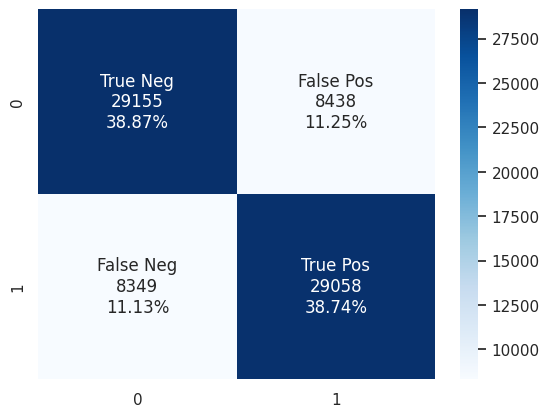

In [65]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [66]:
print(classification_report(Ynn_test.argmax(axis=1),prediction_classes))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78     37593
           1       0.77      0.78      0.78     37407

    accuracy                           0.78     75000
   macro avg       0.78      0.78      0.78     75000
weighted avg       0.78      0.78      0.78     75000



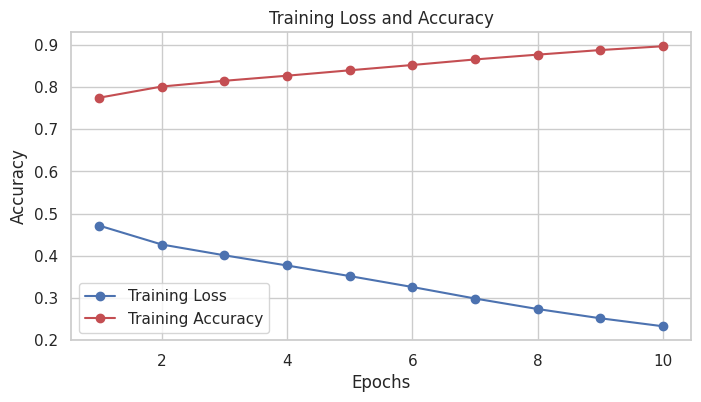

In [67]:
train_loss1 = fittingQA.history['loss']
train_accuracy1 = fittingQA.history['accuracy']
num_epochs = 10
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(8, 4))

# Loss Plot
plt.plot(epochs, train_loss1, 'b-', marker='o', label='Training Loss')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.plot(epochs, train_accuracy1, 'r-', marker='o', label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

The model is trained for 10 epochs on a dataset split into 75% training and 25% testing. The achieved accuracy on the test set is 77%. The classification report indicates balanced performance, with precision, recall, and f1-score metrics showing similar values for both classes (0 and 1). Overall, the neural network demonstrates effective learning.

###<font color=green>GloVe Model

In this step, we are experimenting with employing a different type of embedding: **GloVe**. GloVe, or *Global Vectors for Word Representation*, is an embedding technique designed to capture semantic relationships between words in a corpus. It utilizes global statistics of the entire dataset to generate word embeddings, making it effective in representing word meanings and relationships. We are exploring the use of GloVe to assess its impact on our model's performance.

In [68]:
from gensim.scripts.glove2word2vec import glove2word2vec

In [69]:
word2vec_output_file = 'glove.6B.300d.txt.word2vec'

In [72]:
glove2word2vec('/content/drive/MyDrive/glove.6B.300d.txt', word2vec_output_file)

<ipython-input-72-fcec5e9fda39>:1: DeprecationWarning:

Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).



(400000, 300)

In [73]:
embeddings_index = {}
f = open("/content/drive/MyDrive/glove.6B.300d.txt")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [74]:
embedding_matrix = np.zeros((input_dim, 300))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [75]:
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense, Dropout
modelGL = Sequential()
modelGL.add(Embedding(input_dim, 300, input_length=X.shape[1],weights = [embedding_matrix],trainable = False))
modelGL.add(LSTM(200))
modelGL.add(Dropout(0.5))
modelGL.add(Dense(2, activation='softmax'))

# Compilazione del modello
modelGL.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(modelGL.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 30, 300)           29614200  
                                                                 
 lstm_1 (LSTM)               (None, 200)               400800    
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 402       
                                                                 
Total params: 30015402 (114.50 MB)
Trainable params: 401202 (1.53 MB)
Non-trainable params: 29614200 (112.97 MB)
_________________________________________________________________
None


*Embedding Layer*:
  - Input: Vocabulary size determined by input_dim.
  - Output: Embedding vectors of size 300 for each word.
  - Input Length: Determined by the shape of your input data X.
  - Pre-trained Embedding Weights: Initialized with pre-trained word embeddings (GloVe).
  - Trainable: Set to False to keep the pre-trained embeddings fixed during training.

*LSTM Layer*:
  - Long Short-Term Memory (LSTM) layer with 200 units. This layer captures long-term dependencies in the input sequences.

*Dropout Layer*:
  - Dropout of 0.5 is applied to prevent overfitting, so each neuron in the layer has a 50% probability of being deactivated during training.

*Dense Layer with Softmax Activation*:
  - Output layer with 2 units for binary classification.

In [76]:
batch_size = 32
fittingGL = modelGL.fit(Xnn_train, Ynn_train, epochs = 10, batch_size = batch_size,verbose=2)
fittingGL

Epoch 1/10
7032/7032 - 39s - loss: 0.4911 - accuracy: 0.7618 - 39s/epoch - 6ms/step
Epoch 2/10
7032/7032 - 37s - loss: 0.4431 - accuracy: 0.7918 - 37s/epoch - 5ms/step
Epoch 3/10
7032/7032 - 36s - loss: 0.4169 - accuracy: 0.8066 - 36s/epoch - 5ms/step
Epoch 4/10
7032/7032 - 37s - loss: 0.3907 - accuracy: 0.8208 - 37s/epoch - 5ms/step
Epoch 5/10
7032/7032 - 37s - loss: 0.3631 - accuracy: 0.8348 - 37s/epoch - 5ms/step
Epoch 6/10
7032/7032 - 36s - loss: 0.3355 - accuracy: 0.8494 - 36s/epoch - 5ms/step
Epoch 7/10
7032/7032 - 36s - loss: 0.3091 - accuracy: 0.8626 - 36s/epoch - 5ms/step
Epoch 8/10
7032/7032 - 36s - loss: 0.2854 - accuracy: 0.8739 - 36s/epoch - 5ms/step
Epoch 9/10
7032/7032 - 36s - loss: 0.2653 - accuracy: 0.8843 - 36s/epoch - 5ms/step
Epoch 10/10
7032/7032 - 36s - loss: 0.2480 - accuracy: 0.8922 - 36s/epoch - 5ms/step


In [77]:
score2, acc2 = modelGL.evaluate(Xnn_test, Ynn_test, verbose = 2, batch_size = batch_size)
print("acc: %.2f"%(acc2))

2344/2344 - 8s - loss: 0.5671 - accuracy: 0.7835 - 8s/epoch - 4ms/step
acc: 0.78


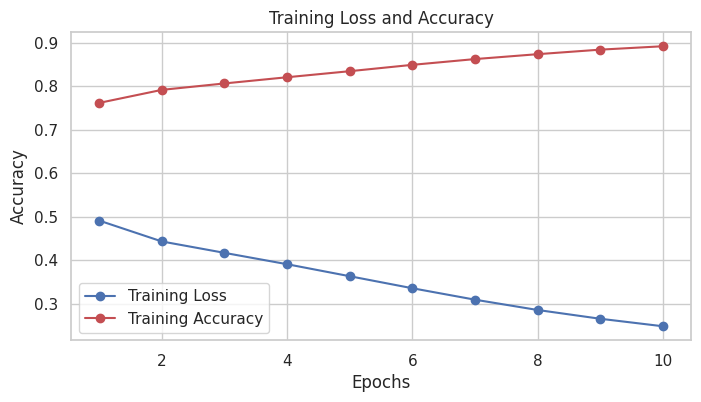

In [78]:
train_loss2 = fittingGL.history['loss']
train_accuracy2 = fittingGL.history['accuracy']
num_epochs = 10
epochs = range(1, num_epochs + 1)

# Crea il grafico
plt.figure(figsize=(8, 4))

# Loss Plot
plt.plot(epochs, train_loss2, 'b-', marker='o', label='Training Loss')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.plot(epochs, train_accuracy2, 'r-', marker='o', label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

The new model implemented with GloVe embedding shows excellent learning capability, as evidenced by the reduction in loss and an increase in accuracy during the training epochs. Evaluation on the test set reveals an improved accuracy of 78%, indicating enhanced generalization and superior performance compared to the model with standard embedding.

### <font color=green>Neural Network with compound

We attempted to enhance the predictive capabilities of our sentiment analysis neural network model. We introduced a new dimension to our dataset by incorporating the *compound* score derived from VADER sentiment analysis.  The addition of this new aspect to our neural network is intended to make the model better at understanding different emotions in tweets. We're investigating how this change affects the overall performance of the model, aiming for a deeper understanding of the emotions expressed in social media messages.

In [79]:
df_sequences = pd.DataFrame(X, columns=[f"word_{i+1}" for i in range(X.shape[1])], index=dataset_compound.index)

df_sequences['compound'] = dataset_compound['compound']

In [80]:
df_sequences

,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9,word_10,...,word_22,word_23,word_24,word_25,word_26,word_27,word_28,word_29,word_30,compound
148479,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,13,489,649,26,0.0000
741760,0,0,0,0,0,0,0,0,0,0,...,2093,1951,40,20,5243,60,147,61,97,-0.2755
739380,0,0,0,0,0,0,0,0,0,0,...,1166,9,1,1124,12,197,490,1,2018,0.0000
612811,0,0,0,0,0,0,0,0,0,0,...,44,61,3211,7,48,1177,24,331,14,0.6124
338052,0,0,0,0,0,0,0,0,0,0,...,287,1866,162,7017,2820,355,278,3212,5974,-0.5106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1177653,0,0,0,0,0,0,0,0,0,0,...,1,574,253,193,3373,24,279,58,2372,-0.6669
1430131,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,63,4729,0.0000
984766,0,0,0,0,0,0,0,0,0,0,...,0,73,28,1,5185,4704,7,10,344,0.7043
1342350,0,0,0,0,0,0,0,0,209,6,...,13,397,644,1527,30,11,2376,3068,2175,0.2675


In [81]:
modelBO = Sequential()
modelBO.add(Embedding(5000, 500, input_length=df_sequences.shape[1]))
modelBO.add(LSTM(200))
modelBO.add(Dropout(0.5))
modelBO.add(Dense(2, activation='softmax'))

modelBO.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(modelBO.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 31, 500)           2500000   
                                                                 
 lstm_2 (LSTM)               (None, 200)               560800    
                                                                 
 dropout_2 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 2)                 402       
                                                                 
Total params: 3061202 (11.68 MB)
Trainable params: 3061202 (11.68 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


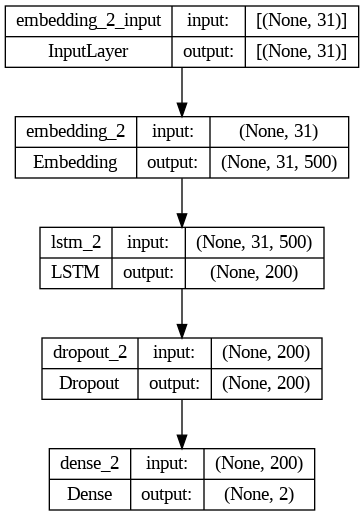

In [82]:
plot_model(modelBO, show_shapes=True, show_layer_names=True)

*Embedding Layer*:
 - Input: Vocabulary size of 5000 words.
 - Output: Embedding vectors of size 500 for each word.
 - Input Length: Determined by the shape of the input sequences (df_sequences).

*LSTM Layer*:
 - Long Short-Term Memory (LSTM) layer with 200 units. This layer captures long-term dependencies in the input sequences.

*Dropout Layer*:
 - Dropout of 0.5 is applied to prevent overfitting, each neuron in the layer has a 50% probability of being deactivated during training.

*Dense Layer with Softmax Activation*:
 - Output layer with 2 units for binary classification (positive or negative sentiment).

In [83]:
XX_train, XX_test, YY_train, YY_test = train_test_split(df_sequences,Y, test_size = 0.25, random_state = 40026)
print(XX_train.shape,YY_train.shape)
print(XX_test.shape,YY_test.shape)

(225000, 31) (225000, 2)
(75000, 31) (75000, 2)


In [ ]:
batch_size = 32
fittingBO = modelBO.fit(XX_train, YY_train, epochs = 10, batch_size=batch_size, verbose = 2)
fittingBO

Epoch 1/10
7032/7032 - 59s - loss: 0.4723 - accuracy: 0.7740 - 59s/epoch - 8ms/step
Epoch 2/10
7032/7032 - 43s - loss: 0.4269 - accuracy: 0.8019 - 43s/epoch - 6ms/step
Epoch 3/10
7032/7032 - 44s - loss: 0.4009 - accuracy: 0.8155 - 44s/epoch - 6ms/step
Epoch 4/10
7032/7032 - 43s - loss: 0.3748 - accuracy: 0.8290 - 43s/epoch - 6ms/step
Epoch 5/10
7032/7032 - 42s - loss: 0.3444 - accuracy: 0.8441 - 42s/epoch - 6ms/step
Epoch 6/10
7032/7032 - 42s - loss: 0.3116 - accuracy: 0.8598 - 42s/epoch - 6ms/step
Epoch 7/10
7032/7032 - 43s - loss: 0.2773 - accuracy: 0.8773 - 43s/epoch - 6ms/step
Epoch 8/10
7032/7032 - 42s - loss: 0.2445 - accuracy: 0.8918 - 42s/epoch - 6ms/step
Epoch 9/10
7032/7032 - 42s - loss: 0.2177 - accuracy: 0.9048 - 42s/epoch - 6ms/step
Epoch 10/10
7032/7032 - 41s - loss: 0.1951 - accuracy: 0.9154 - 41s/epoch - 6ms/step


In [ ]:
predictions1 = modelBO.predict(XX_test)
predictions1

2344/2344 [==============================] - 8s 3ms/step


array([[6.5670979e-01, 3.4329021e-01],
       [1.7171720e-04, 9.9982822e-01],
       [9.9967873e-01, 3.2128734e-04],
       ...,
       [1.3641460e-04, 9.9986362e-01],
       [1.0000000e+00, 1.0847976e-09],
       [2.3822191e-04, 9.9976176e-01]], dtype=float32)

In [ ]:
prediction_classes1=np.argmax(predictions1,axis=1)
prediction_classes1

array([0, 1, 0, ..., 1, 0, 1])

In [ ]:
score1,acc1 = modelBO.evaluate(XX_test, YY_test, verbose = 2, batch_size = batch_size)

print("acc: %.2f" % (acc1))

2344/2344 - 7s - loss: 0.7447 - accuracy: 0.7737 - 7s/epoch - 3ms/step
acc: 0.77


In [ ]:
cf_matrix1 = confusion_matrix(YY_test.argmax(axis=1),prediction_classes1)

<Axes: >

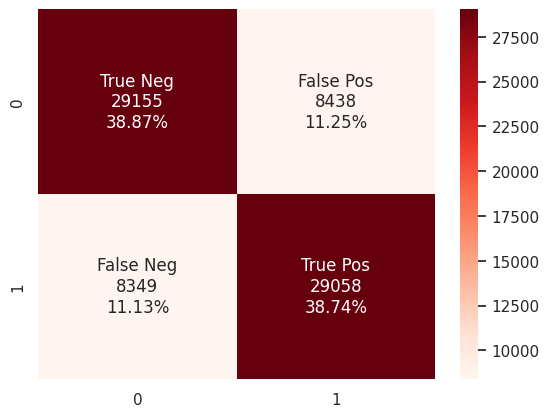

In [ ]:
group_names1 = ['True Neg','False Pos','False Neg','True Pos']
group_counts1 = ["{0:0.0f}".format(value) for value in
                cf_matrix1.flatten()]
group_percentages1 = ["{0:.2%}".format(value) for value in
                     cf_matrix1.flatten()/np.sum(cf_matrix1)]
labels1 = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels1 = np.asarray(labels1).reshape(2,2)
sns.heatmap(cf_matrix1, annot=labels, fmt='', cmap='Reds')

In [ ]:
print(classification_report(YY_test.argmax(axis=1),prediction_classes1))

              precision    recall  f1-score   support

           0       0.78      0.77      0.77     37593
           1       0.77      0.77      0.77     37407

    accuracy                           0.77     75000
   macro avg       0.77      0.77      0.77     75000
weighted avg       0.77      0.77      0.77     75000



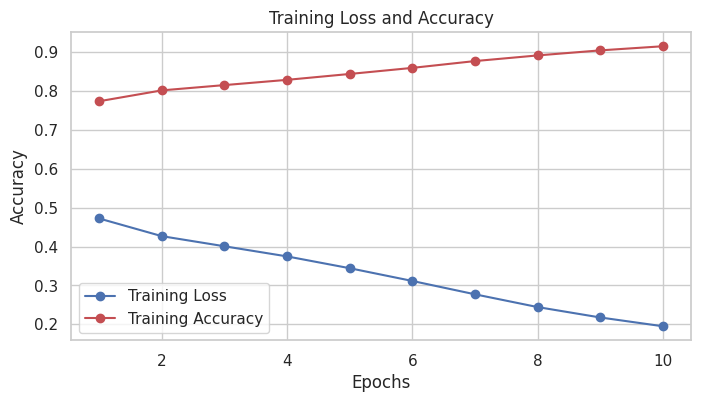

In [ ]:
train_loss = fittingBO.history['loss']
train_accuracy = fittingBO.history['accuracy']
num_epochs = 10
epochs = range(1, num_epochs + 1)

# Crea il grafico
plt.figure(figsize=(8, 4))

# Loss Plot
plt.plot(epochs, train_loss, 'b-', marker='o', label='Training Loss')
plt.title('Training Loss and Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.plot(epochs, train_accuracy, 'r-', marker='o', label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

The new neural network model, integrated with the "compound" score derived from VADER, has demonstrated an accuracy of 77%, consistent with the performance of the previous model that did not include the "compound." Its learning capacity is evident from the reduction in loss during training. However, it's noteworthy that the addition of the "compound" score did not lead to a significant improvement in overall performance. This may suggest that the previous model, without the "compound," already effectively captured relevant information from the tweets for sentiment classification. Further steps could involve optimizing the model architecture or exploring additional features to further refine the predictive capability of the system.

### <font color=green>Comparing Neural Network models

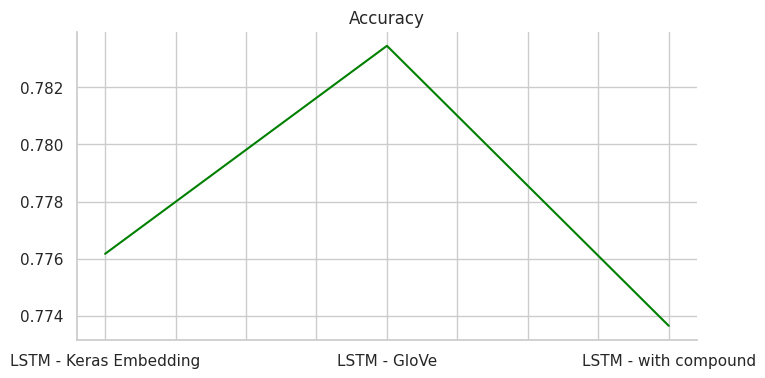

In [ ]:
accuracies = [acc,acc2,acc1]

# create a DataFrame with only the accuracy column
results_df = pd.DataFrame({"Accuracy": accuracies}, index=["LSTM - Keras Embedding", "LSTM - GloVe", "LSTM - with compound"])

from matplotlib import pyplot as plt
results_df['Accuracy'].plot(kind='line', figsize=(8, 4), title='Accuracy',color = "green")
plt.gca().spines[['top', 'right']].set_visible(False)

### <font color=green>Comparing ML and NN

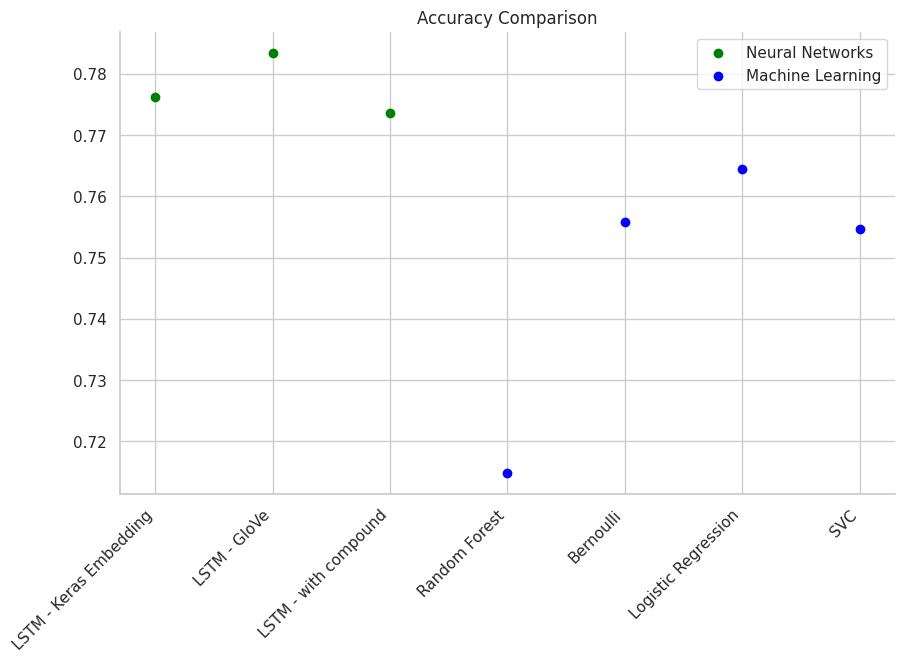

In [ ]:
from matplotlib import pyplot as plt
from sklearn import metrics

# accuracies for the first set of models
accuracies_lstm = [acc, acc2, acc1]
model_names_lstm = ["LSTM - Keras Embedding", "LSTM - GloVe", "LSTM - with compound"]

# accuracies for the second set of models
accuracies_other = [
    metrics.accuracy_score(y_test, predictions_RF),
    metrics.accuracy_score(y_test, predictions_bernoulli),
    metrics.accuracy_score(y_test, predictions_log),
    metrics.accuracy_score(y_test, predictions_SVC),
]
model_names_other = ["Random Forest", "Bernoulli", "Logistic Regression", "SVC"]


results_df_lstm = pd.DataFrame({"Accuracy": accuracies_lstm}, index=model_names_lstm)
results_df_other = pd.DataFrame({"Accuracy": accuracies_other}, index=model_names_other)


# plot both sets of models in a single figure
fig, ax = plt.subplots(figsize=(10, 6))

# plot scatter plot for LSTM models
ax.scatter(model_names_lstm, accuracies_lstm, color='green', label='Neural Networks')

# plot scatter plot for Other models
ax.scatter(model_names_other, accuracies_other, color='blue', label='Machine Learning')

ax.set_title('Accuracy Comparison')
ax.spines[['top', 'right']].set_visible(False)


combined_model_names = model_names_lstm + model_names_other
ax.set_xticks(range(len(combined_model_names)))
ax.set_xticklabels(combined_model_names, rotation=45, ha="right")

ax.legend()

plt.show()

In our comparative analysis between traditional machine learning models and LSTM-based neural networks applied to tweet sentiment analysis, the results indicate a small advantage in favor of neural architectures.
As depicted in the graph, the accuracies achieved through neural networks range from almost 77% with the basic LSTM model to nearly 78.5% when incorporating GloVe into the LSTM-based neural network. In contrast, traditional machine learning models exhibit slightly lower accuracy, ranging from approximately 71% with Random Forest to 76% with Logistic Regression, which appears to be the most performant model within the traditional ML group.

Neural networks (NN) demonstrate superior performance due to their ability to learn complex patterns and sequential dependencies within textual data. Specifically, architectures like LSTM are very efficient in capturing sentiments and contextual relationships among words, while techniques such as GloVe embeddings enhance semantic understanding.
In contrast, traditional Machine Learning (ML) models often rely on simpler representations, such as bag-of-words, which may struggle to capture the semantic richness inherent in language. The absence of embedded semantic information can limit the ability of traditional ML models to discern subtle contextual meanings and intricate relationships between words, giving NNs a distinct advantage in tasks that demand a deeper comprehension of textual data.